In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# 載入資料集

In [3]:
x, y = load_breast_cancer(return_X_y=True)
y[y==0] = -1
print(x.shape)
print(y.shape)

(569, 30)
(569,)


# 顯示資料分佈

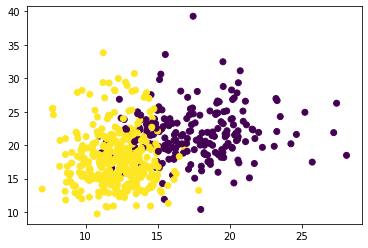

In [4]:
plt.scatter(x[:, 0], x[:, 1], c=y)

# 拆分訓練集與測試集

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y)
print(x_train.shape)
print(y_train.shape)

(426, 30)
(426,)


# 主要算法實現

In [6]:
class DecisionStump:
    """以決策樹樹樁作為弱分類器"""
    def __init__(self, feature_idx, threshold):
        self.feature_idx = feature_idx
        self.threshold = threshold

        # 若錯誤率超過一半則翻轉其判斷條件
        self.fliped = False

    def calc_error(self, x, y, w, return_fliped=False):
        """
        計算此分類器的錯誤率
        錯誤率相當於分錯的樣本權重的總和
        return_fliped回傳錯誤率是否經過翻轉
        """
        misclassfied_w = w[y != self.predict(x)]
        error = misclassfied_w.sum()

        error, fliped = (1 - error, True) if error > 0.5 else (error, False)
        if return_fliped:
            return error, fliped
        return error

    def predict(self, x):
        """僅根據單一特徵與單一閾值預測"""
        x_column = x[:, self.feature_idx]
        preds = np.where(x_column > self.threshold, 1, -1)
        if self.fliped:
            return -preds
        return preds

In [7]:
class AdaBoost:
    """
    線性加權多個弱分類器形成強分類器
    參考資料: https://github.com/aespresso/a_journey_into_math_of_ml/blob/master/02_adaboost/adaboost.ipynb
    """
    def __init__(self, n_clfs):
        self.n_clfs = n_clfs

    def fit(self, x, y):
        """依設定的數目生成多個弱分類器"""
        # 初始化樣本權重 僅有一份且會隨新增分類器而更新
        n_samples = len(x)
        w = np.full(n_samples, 1/n_samples)

        # 生成弱分類器
        self.clfs = []
        for _ in range(self.n_clfs):
            clf = self._make_best_clf(x, y, w)

            # 每個弱分類器皆有其分類器權重(alpha)
            # 弱分類器權重由錯誤率計算而得
            # 令損失對分類器權重的導數為0
            # 使該分類器權重(alpha)能最小化損失
            error, fliped = clf.calc_error(x, y, w, return_fliped=True)
            clf.fliped = fliped
            clf.alpha = 0.5 * np.log((1 - error) / error)

            self.clfs.append(clf)
            w = self._update_w(w, clf.alpha, clf.predict(x), y)

    def predict(self, x):
        """預測時取所有弱分類器的總和"""
        # 初始化每個分類器權重(alpha)時與前一權重相關
        # 但在預測階段可平行即無串聯關係
        preds = np.sum([ clf.alpha * clf.predict(x) for clf in self.clfs ], axis=0)
        return np.sign(preds)

    def _make_best_clf(self, x, y, w):
        """
        先以各種特徵與閾值的組合生成多個弱分類器
        從中挑出能最小化錯誤率的
        """
        clfs = []
        n_features = x.shape[1]
        for feature_idx in range(n_features):
            for threshold in np.unique(x[:, feature_idx]):
                clf = DecisionStump(feature_idx, threshold)
                clfs.append(clf)
        return min(clfs, key=lambda clf: clf.calc_error(x, y, w))

    def _update_w(self, w, alpha, preds, y):
        """每次新增弱分類器後更新樣本權重"""
        w *= np.exp(-alpha * preds * y)
        w /= w.sum() # 歸一化
        return w

In [8]:
ada_boost = AdaBoost(n_clfs=5)
ada_boost.fit(x_train, y_train)

# 驗證算法準確率

In [10]:
preds = ada_boost.predict(x_test)
print("Accuracy:", (preds == y_test).mean())

Accuracy: 0.958041958041958


# 可視化驗證

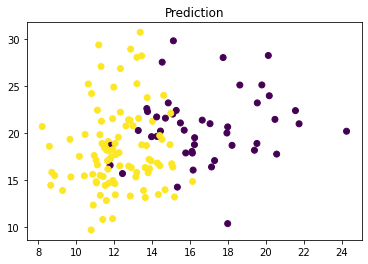

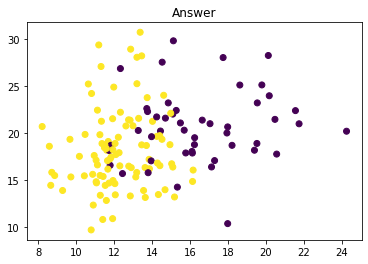

In [11]:
plt.title("Prediction")
plt.scatter(x_test[:, 0], x_test[:, 1], c=preds)
plt.show()

plt.title("Answer")
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
plt.show()